In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import scipy
from scipy.interpolate import make_interp_spline, BSpline

import seaborn as sns

from cmdstanpy import CmdStanModel
import arviz as az

import json

from scipy import stats


In [16]:
def scaler(data):
    return (data - 0)/(data.max()-0)

def scaler_rev(data, norm):
    return (data+1e-3)*(norm.max()-0) + 0

def Co_n_error(Co, dCo, Fe,dFe,Mn,dMn):
    return 50/(Fe+Mn)*dCo + 50*Co/(Fe+Mn)**2*dFe + 50*Co/(Fe+Mn)**2*dMn

def func_e(x,alpha,beta,a,b, c,e):
    return c*a/(b*pow(alpha, b)*beta)*(1-np.exp(-b*x*beta)) +e

def func_exp(x, alpha, beta):
    return alpha*np.exp(beta*x)

def func_(x,alpha,beta,a,b,c,e):
    return a*c/((b-1)*beta)*(pow(alpha,(1-b)) - pow((beta*x + alpha),(1-b))) + e

def func_lin(x,alpha,beta):
    return beta*x+alpha

def func_Co_n_error(Co, dCo, Fe,dFe,Mn,dMn):
    return 50/(Fe+Mn)*dCo + 50*Co/(Fe+Mn)**2*dFe + 50*Co/(Fe+Mn)**2*dMn

def func_Co_n(Co, Fe, Mn):
    return 50*Co/(Fe+Mn)

In [17]:
root = "./tools/GR_results.xlsx" # change this to ~/Agemodeldatamgbc202141.xlsx
df_results = pd.read_excel(root)
df_results.columns = ["depth", "GR"]

In [44]:
root = "./tools/Agemodeldatamgbc202141.xlsx" # change this to ~/Agemodeldatamgbc202141.xlsx
df = pd.read_excel(root, skiprows = np.arange(0,3))

dataDict = {}

dataDict["Ages"] = np.concatenate([df["Pb-age"].values[:4],df["Age"].values[:2]], axis = 0)
dataDict["Ages_error"] = np.concatenate([df["2σ.5"].values[:4]/2,df["±.3"].values[:2]/2], axis = 0) 

dataDict["Ages_d"] = np.concatenate([df["depth (mm)"].values[:4],df["Depth (mm)"].values[:2]], axis = 0)*1e-3
dataDict["Ages_d_error"] = np.concatenate([df["±.1"].values[:4], df["±.2"].values[:2]], axis = 0)*1e-3*0.5

dataDict["Co_d"] = df["Sampling depth (mm)"].values*1e-3
dataDict["Co_d_error"] = (df["±"].values*1e-3)/2

dataDict["Co"] = 50*df["Co (wt-%)"].values/(df["Fe (wt-%)"].values + df["Mn (wt-%)"].values)

dataDict["Co_"] = df["Co (wt-%)"].values
dataDict["Co_sigma"] = df['2σ.2'].values/2

dataDict["Fe_"] = df["Fe (wt-%)"].values 
dataDict["Fe_sigma"] = df['2σ'].values/2

dataDict["Mn_"] = df["Mn (wt-%)"].values
dataDict["Mn_sigma"] = df['2σ.1'].values/2


In [47]:

datas = {}


datas["Ages"] = (dataDict["Ages"]*1e-4).tolist()
datas["Ages_error"] = np.abs(dataDict["Ages_error"]*1e-4).tolist()

datas["Co_"] = (dataDict["Co_"]).tolist() 
datas["Co_e"] =  np.abs((dataDict["Co_sigma"])).tolist()

datas["Fe_"] = (dataDict["Fe_"]).tolist() 
datas["Fe_e"] =  np.abs((dataDict["Fe_sigma"])).tolist()

datas["Mn_"] = (dataDict["Mn_"]).tolist() 
datas["Mn_e"] =  np.abs((dataDict["Mn_sigma"])).tolist()


datas["Co_d"] = (dataDict["Co_d"]*100).tolist()
datas["Co_d_error"] = np.abs(dataDict["Co_d_error"]*100).tolist()

datas["Ages_d"] = (dataDict["Ages_d"]*100).tolist()
datas["Ages_d_error"] = np.abs(dataDict["Ages_d_error"]*100).tolist()

datas["n_i"] = len(dataDict["Co"])
datas["n_j"] = len(dataDict["Ages"])

datas['n_Co_n_indices'] = (np.arange(datas['n_i'])+1).tolist()
datas['n_Co_indices'] = (np.arange(datas['n_i'])+datas['n_i']+1).tolist()
datas['n_j_indices'] = (np.arange(datas['n_j'])+int(2*datas['n_i'])+1).tolist()

with open('data_.json','w') as f:
    json.dump(datas,f)



Exp fit
 0.03753484188306763 -0.015108723741481422
Fit func_(x,alpha,beta,a,b,e): 
 1.0 1.0 1.0 1.0 1.0 1.0


C:\Users\Arttu\AppData\Local\Temp\ipykernel_11528\2086191109.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  return a*c/((b-1)*beta)*(pow(alpha,(1-b)) - pow((beta*x + alpha),(1-b))) + e
C:\Users\Arttu\AppData\Local\Temp\ipykernel_11528\2086191109.py:17: RuntimeWarning: invalid value encountered in multiply
  return a*c/((b-1)*beta)*(pow(alpha,(1-b)) - pow((beta*x + alpha),(1-b))) + e
C:\Users\Arttu\AppData\Local\Temp\ipykernel_11528\3540861888.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func_, datas["Ages_d"], datas["Ages"], maxfev = 1000000)


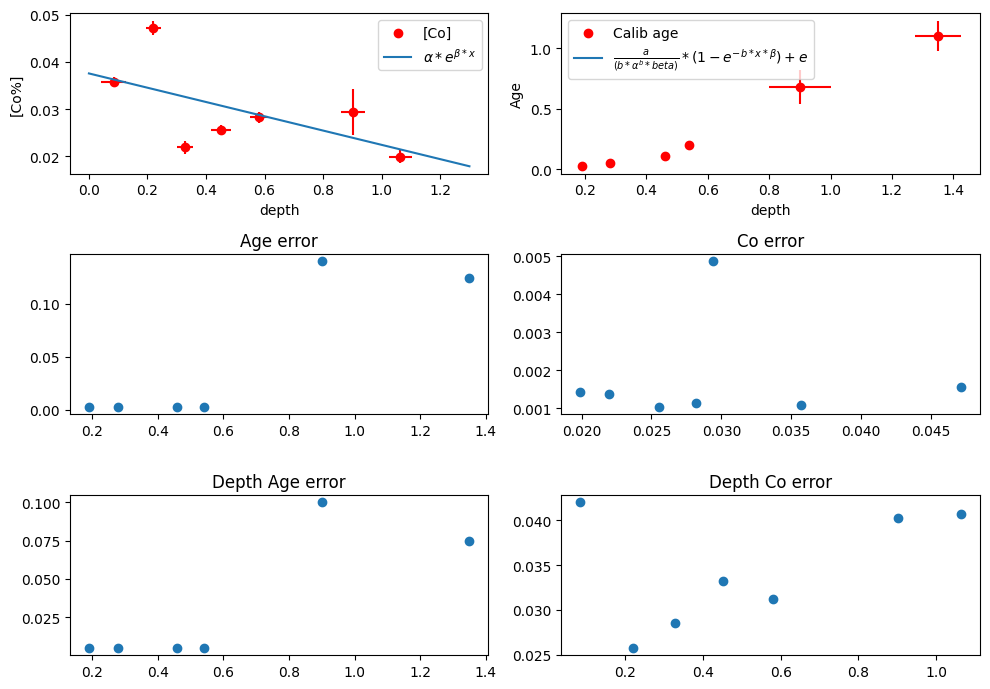

In [46]:
Co_ = func_Co_n(dataDict["Co_"], dataDict["Fe_"], dataDict["Mn_"])
Co_error = func_Co_n_error(dataDict["Co_"] ,dataDict["Co_sigma"] ,dataDict["Fe_"] ,dataDict["Fe_sigma"],dataDict["Mn_"] ,dataDict["Mn_sigma"] )

xdata_Co = np.arange(0,np.concatenate((datas["Ages_d"], datas["Co_d"])).max(), 0.1)
popt, pcov = curve_fit(func_lin, datas["Co_d"], Co_)
ydata_Co = func_lin(xdata_Co, *popt)

print("Exp fit\n", *popt)

bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf,-np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
guess = np.array([0.1, -2, 1e-3, 0.1, 0.1, 0.1])

popt, pcov = curve_fit(func_, datas["Ages_d"], datas["Ages"], maxfev = 1000000)
ydata_Ages = func_(xdata_Co, *popt)

print("Fit func_(x,alpha,beta,a,b,e): \n", *popt)


fig, ax = plt.subplots(3,2,figsize=(10,7))

ax[0,0].errorbar(datas["Co_d"], Co_, xerr = datas["Co_d_error"],yerr=Co_error, fmt=' ',color = "red")
ax[0,0].scatter(datas["Co_d"], Co_, color = "red", label = "[Co]")

ax[0,0].plot(xdata_Co, ydata_Co, label = r"$\alpha*e^{\beta*x}$")
#ax[0,0].set_ylim(0,0.1)
#ax[0].set_ylim(0,1)

ax[0,0].set_ylabel("[Co%]")
ax[0,0].set_xlabel("depth")
ax[0,0].legend()

ax[0,1].errorbar(datas["Ages_d"], datas["Ages"], xerr = datas["Ages_d_error"], yerr=datas["Ages_error"], fmt=' ',color = "red")
ax[0,1].scatter(datas["Ages_d"], datas["Ages"],color = "red", label = "Calib age")
ax[0,1].plot(xdata_Co, ydata_Ages, label = r"$\frac{a}{(b*\alpha^b*beta)}*(1-e^{-b*x*\beta}) + e$")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")

ax[0,1].set_ylabel("Age")
ax[0,1].set_xlabel("depth")
ax[0,1].legend()


ax[1,0].set_title("Age error")
ax[1,0].scatter(datas["Ages_d"],datas["Ages_error"], label = "calib age")
ax[1,1].set_title("Co error")
ax[1,1].scatter(Co_, Co_error,  label = "[Co]")

ax[2,0].set_title("Depth Age error")
ax[2,0].scatter(datas["Ages_d"],datas["Ages_d_error"], label = "calib age")
ax[2,1].set_title("Depth Co error")
ax[2,1].scatter(datas["Co_d"], datas["Co_d_error"],  label = "[Co]")

fig.tight_layout()

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib tk


fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(8, 5))

def plot_func(alpha,beta,a,b): #c, e
    
    ax[1].scatter(datas["Ages_d"], datas["Ages"])
    ax[1].errorbar(datas["Ages_d"], datas["Ages"], xerr = datas["Ages_d_error"],yerr=datas["Ages_error"], fmt=' ',color = "red")

    x = np.linspace(0, 1.5, 100)
    yy = a/((b-1)*beta)*(pow(alpha,(1-b)) - pow((beta*x + alpha),(1-b))) # c e

    ax[1].plot(x, yy)
    ax[1].set_ylim((0,2))

    y = alpha+beta*x

    ax[0].plot(x, y)
    ax[0].scatter(datas["Co_d"], 10*(50*np.array(datas["Co_"]))/(np.array(datas["Fe_"])+np.array(datas["Mn_"])))
    #ax[0].errorbar(datas["Co_d"], datas["Co"], xerr = datas["Co_d_error"], yerr=datas["Co_error"], fmt=' ',color = "red")



alpha_init = 0.35
beta_init= -0.3
a_init = 0.1
b_init = 1

ax[1].set_ylim((0,2))

interact(plot_func, alpha = widgets.FloatSlider(value=alpha_init,
                                               min=0,
                                               max=1,
                                               step=0.01), 
                    beta = widgets.FloatSlider(value=beta_init,
                                               min=-5,
                                               max=0,                                    
                                               step=0.01),
                    a = widgets.FloatSlider(value=a_init,
                                               min=-2,
                                               max=2,
                                               step=0.01), 
                    b = widgets.FloatSlider(value=b_init,
                                               min=-2,
                                               max=2,
                                               step=0.01)
                                               )

"""
,
                    c = widgets.FloatSlider(value=c_init,
                                               min=-2,
                                               max=2,
                                               step=0.01), 
                    e = widgets.FloatSlider(value=e_init,
                                               min=-2,
                                               max=2,
                                               step=0.01)
"""


interactive(children=(FloatSlider(value=0.4, description='alpha', max=1.0, step=0.01), FloatSlider(value=-0.2,…

'\n,\n                    c = widgets.FloatSlider(value=c_init,\n                                               min=-2,\n                                               max=2,\n                                               step=0.01), \n                    e = widgets.FloatSlider(value=e_init,\n                                               min=-2,\n                                               max=2,\n                                               step=0.01)\n'

In [70]:
model = CmdStanModel(stan_file='C:/Users/Arttu/Desktop/Codes/TeachingSolution/AgeModel/minSol_mod_lin.stan')
fit = model.sample(data='C:/Users/Arttu/Desktop/Codes/TeachingSolution/AgeModel/data_.json', adapt_delta=0.9999,max_treedepth=20)  #, adapt_delta=0.9999,max_treedepth=20 show_console=True) #, 

print(fit.diagnose())
fit.summary()

21:01:49 - cmdstanpy - INFO - compiling stan file C:\Users\Arttu\Desktop\Codes\TeachingSolution\AgeModel\minSol_mod_lin.stan to exe file C:\Users\Arttu\Desktop\Codes\TeachingSolution\AgeModel\minSol_mod_lin.exe
21:02:40 - cmdstanpy - INFO - compiled model executable: C:\Users\Arttu\Desktop\Codes\TeachingSolution\AgeModel\minSol_mod_lin.exe
21:02:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:32:13 - cmdstanpy - INFO - CmdStan done processing.
21:32:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_lin.stan', line 109, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_lin.stan', line 109, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[1] is nan, but must be finite! (in 'minSol_mod_lin.stan', line 139, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[2] is nan, but must be finite! (in 'minSol_mod_lin.stan', line 139, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[2] is nan, but must be finite! (in 'minSol_mod_lin.stan', line 139, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[3] is nan, but must be finite! (in 'minSol_mod_lin.stan', line 139, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but

21:32:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 24 divergent transitions (2.4%)
	Chain 2 had 50 divergent transitions (5.0%)
	Chain 3 had 64 divergent transitions (6.4%)
	Chain 4 had 43 divergent transitions (4.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Processing csv files: C:\Users\Arttu\AppData\Local\Temp\tmpvjgn7s8n\minSol_mod_linuw4c1k8j\minSol_mod_lin-20250126210241_1.csv, C:\Users\Arttu\AppData\Local\Temp\tmpvjgn7s8n\minSol_mod_linuw4c1k8j\minSol_mod_lin-20250126210241_2.csv, C:\Users\Arttu\AppData\Local\Temp\tmpvjgn7s8n\minSol_mod_linuw4c1k8j\minSol_mod_lin-20250126210241_3.csv, C:\Users\Arttu\AppData\Local\Temp\tmpvjgn7s8n\minSol_mod_linuw4c1k8j\minSol_mod_lin-20250126210241_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
181 of 4000 (4.53%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactor

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-29.236600,0.198082,6.753690,-41.377000,-28.939900,-18.893400,1162.50,5.69927,1.000860
alpha,0.412201,0.001638,0.069411,0.300628,0.410510,0.527560,1794.95,8.79991,1.001890
beta,-0.275366,0.001335,0.057087,-0.370384,-0.276719,-0.181509,1827.88,8.96134,1.000640
a,0.122285,0.000975,0.037267,0.067808,0.119468,0.190932,1460.69,7.16115,1.001630
b,1.017840,0.001622,0.093426,0.863520,1.016300,1.170540,3318.68,16.27010,0.999831
...,...,...,...,...,...,...,...,...,...
y_hat[16],0.093939,0.001633,0.099702,-0.052245,0.088317,0.249776,3729.76,18.28550,1.000330
y_hat[17],0.166784,0.001883,0.115989,0.005878,0.157916,0.353809,3795.56,18.60800,0.999935
y_hat[18],0.200327,0.001850,0.101226,0.040058,0.200172,0.355679,2995.40,14.68520,1.000230
y_hat[19],0.458396,0.004356,0.235917,0.062449,0.473078,0.797440,2933.21,14.38030,0.999378


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (34), generating only 20 plots
  warnings.warn(


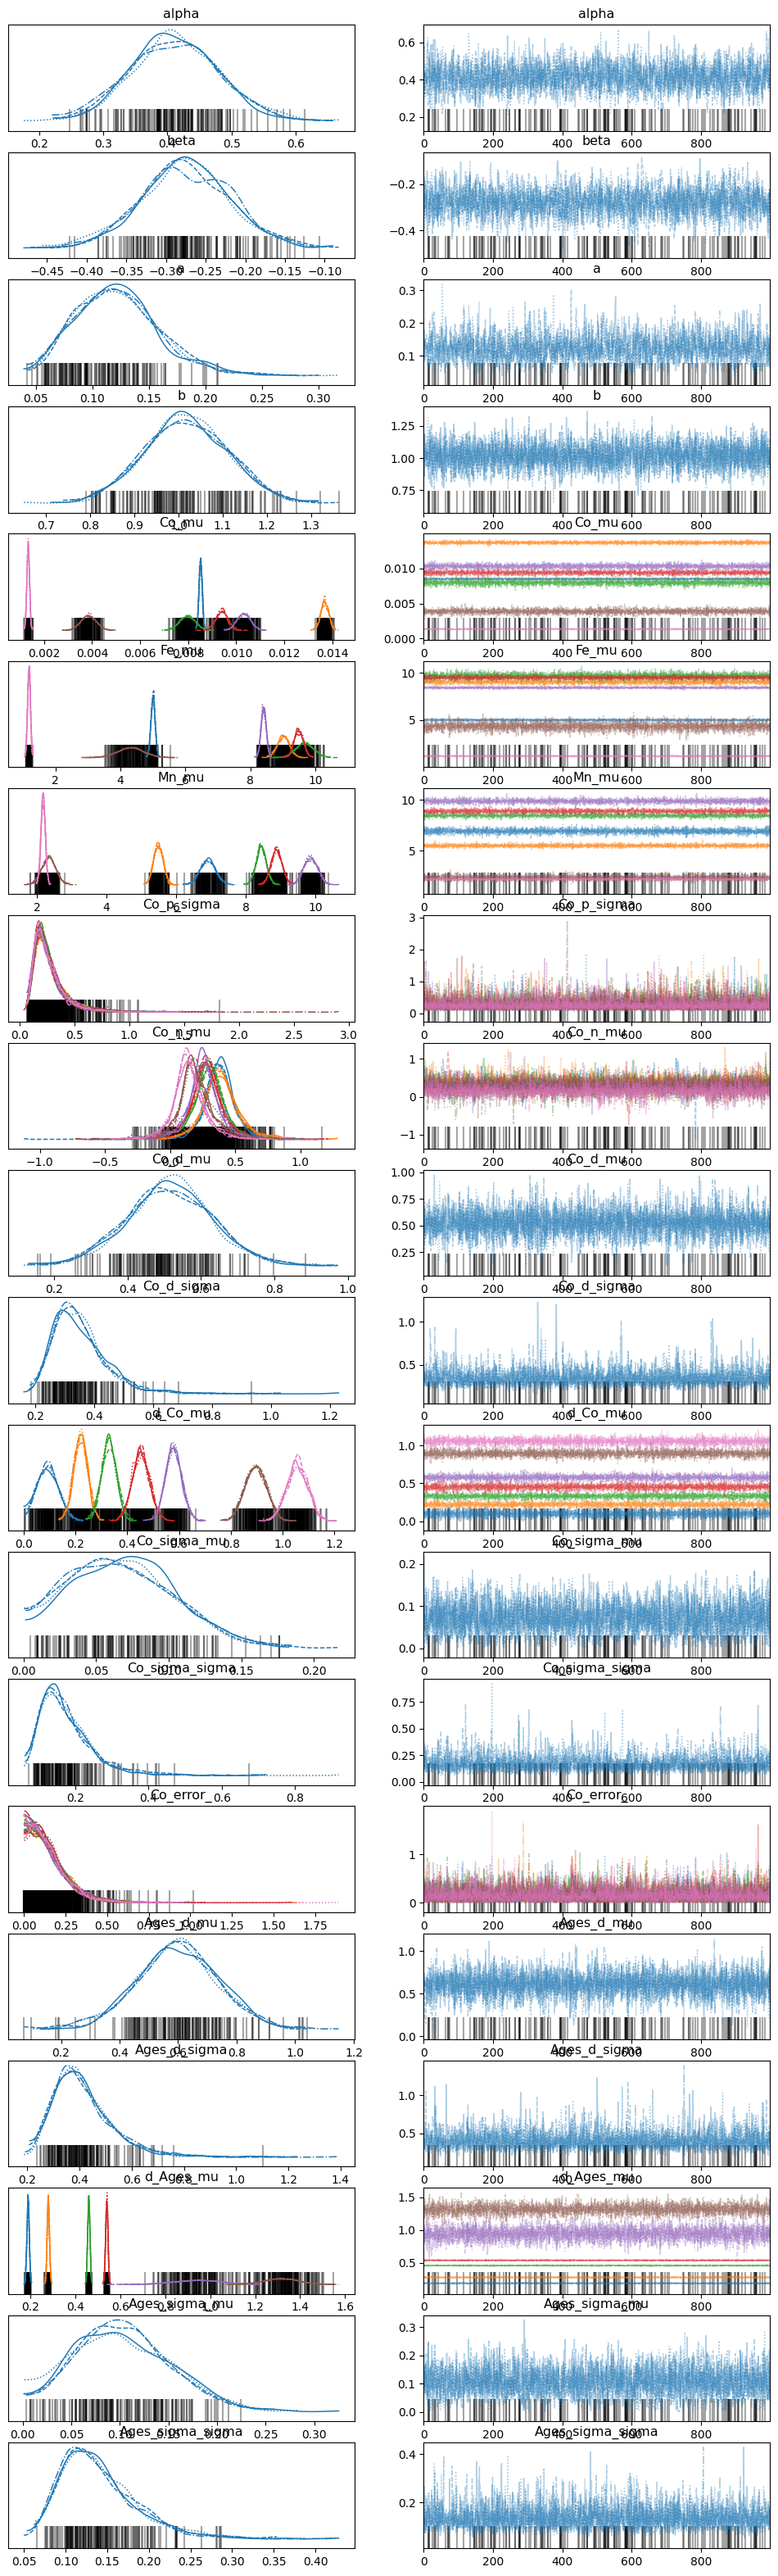

In [71]:
%matplotlib inline

azOut = az.from_cmdstanpy(posterior=fit)


#_ = az.plot_posterior(azOut)
_ = az.plot_trace(azOut)



Computed from 4000 posterior samples and 27 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    47.26    15.52
p_loo       24.84        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        2    7.4%
   (0.70, 1]   (bad)        18   66.7%
   (1, Inf)   (very bad)    7   25.9%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

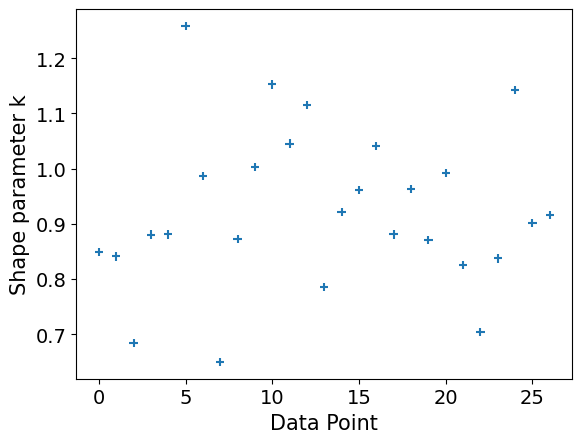

In [72]:
loo = az.loo(azOut,pointwise=True)
print(loo)

az.plot_khat(loo)

C:\Users\Arttu\AppData\Local\Temp\ipykernel_11528\492492883.py:49: RuntimeWarning: invalid value encountered in power
  yy = a/((b-1)*beta)*(pow(alpha,(1-b)) - pow((beta*xx + alpha),(1-b)))
C:\Users\Arttu\AppData\Local\Temp\ipykernel_11528\492492883.py:66: RuntimeWarning: invalid value encountered in power
  yy = 1/(a/(alpha + beta*xx)**b)


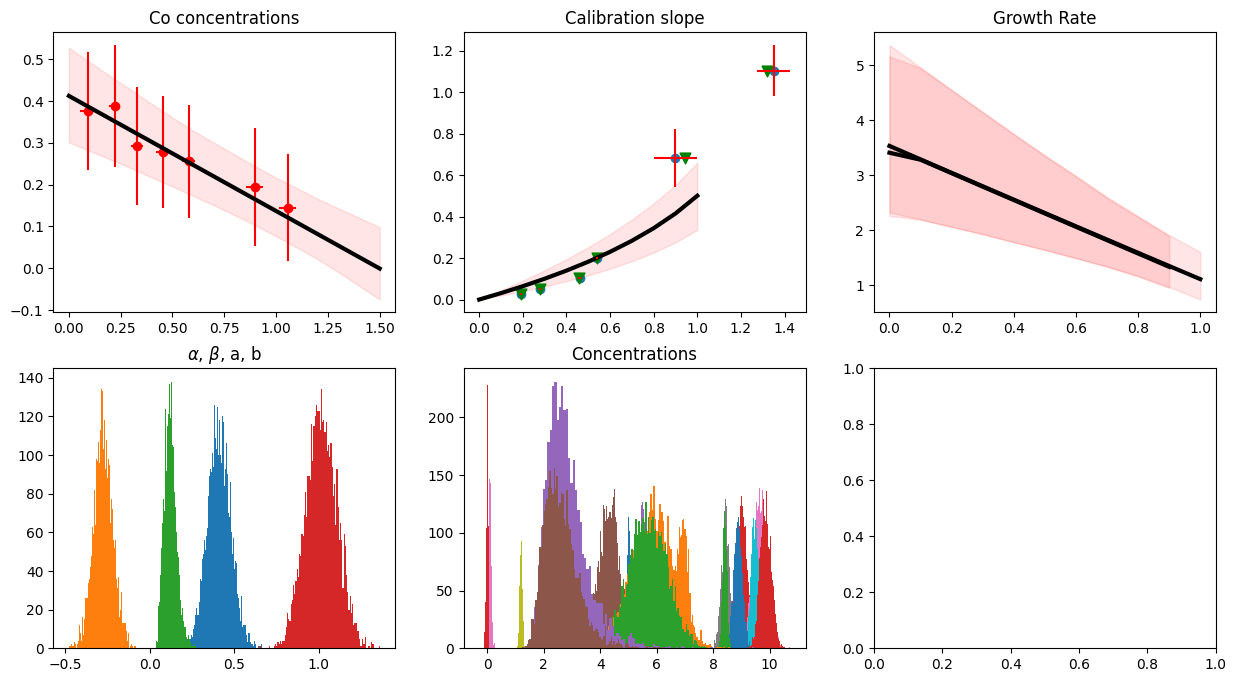

In [73]:
draws = fit.draws_pd()
draws.keys()

alpha = draws['alpha'].values[...,None]
beta = draws['beta'].values[...,None]

a = draws['a'].values[...,None]
b = draws['b'].values[...,None]

Co_mu = np.array(draws.filter(regex='^Co_mu'))
Fe_mu = np.array(draws.filter(regex='^Fe_mu'))
Mn_mu = np.array(draws.filter(regex='^Mn_mu'))

Co = np.array(draws.filter(regex='^Co_n_mu'))
Co_d = np.array(draws.filter(regex='^d_Co_mu'))

fig, ax = plt.subplots(2,3,figsize=(15,8))

ax[1,0].set_title(r"$\alpha$, $\beta$, a, b")
_ = ax[1,0].hist(alpha, bins = 100)
_ = ax[1,0].hist(beta, bins = 100)
_ = ax[1,0].hist(a, bins = 100)
_ = ax[1,0].hist(b, bins = 100)

# Co concentration

xx = np.mean(Co_d, axis = 0)
means = np.mean(Co, axis = 0)

xx_error = np.std(Co_d, axis = 0)
means_error = np.std(Co, axis = 0)

ax[0,0].scatter(xx,means,color = "red", label='mean')
ax[0,0].errorbar(xx,means, xerr = xx_error,yerr= means_error, fmt=' ',color = "red")

xx = np.arange(0, np.max(datas["Co_d"])+0.5,1e-1)
yy = beta*xx + alpha

means = np.mean(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[0,0].plot(xx,means,"black",linewidth=3,label='mean')
ax[0,0].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)
ax[0,0].set_title("Co concentrations")

# Age
xx = np.arange(0, np.max(datas["Ages_d"]),1e-1)
yy = a/((b-1)*beta)*(pow(alpha,(1-b)) - pow((beta*xx + alpha),(1-b)))

means = np.mean(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[0,1].plot(xx,means,"black",linewidth=3,label='mean')
ax[0,1].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)
ax[0,1].scatter(datas["Ages_d"], datas["Ages"])
ax[0,1].errorbar(datas["Ages_d"], datas["Ages"], xerr = datas["Ages_d_error"],yerr=datas["Ages_error"], fmt=' ',color = "red")
ax[0,1].scatter(draws.filter(regex='d_Ages_mu').mean(axis=0).values, datas["Ages"],color = "green",marker='v',s=60)
ax[0,1].set_title("Calibration slope")

yy_year = yy

#GR
#xx = np.arange(0, np.max(datas["Ages_d"])+1,1e-1) #np.max(datas["Co_d"])
yy = 1/(a/(alpha + beta*xx)**b)

means = np.mean(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[0,2].plot(xx,means,"black",linewidth=3,label='mean - analytical')
ax[0,2].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)

GR_yy = np.gradient(xx, axis = 0)/np.gradient(yy_year, axis = 1) #m/years -> mm/years

means = np.mean(GR_yy, axis = 0)
p95s = np.percentile(GR_yy, 95, axis = 0)
p5s = np.percentile(GR_yy, 5, axis = 0)

ax[0,2].plot(xx,means,"black",linewidth=3,label='mean - numeric')
ax[0,2].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)
ax[0,2].set_title("Growth Rate")

ax[1,1].set_title(r"Concentrations")

for i in range(Fe_mu.shape[1]):
    _ = ax[1,1].hist(Fe_mu[:,i], bins = 100)
    _ = ax[1,1].hist(Mn_mu[:,i], bins = 100)
    _ = ax[1,1].hist(Co_mu[:,i], bins = 100)